In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from gaussian_mixture_grid import GaussianMixtureGrid
import numpy as np
import pymc3 as pm
import matplotlib.cm as cm

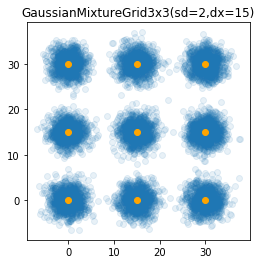

In [55]:
gri2d = GaussianMixtureGrid(length=3, dimensionality=2, spacing=15, stddev=2) 
# spacing 10 -- works well
# spacing 30 -- only finds one mode
plt.figure(figsize=(4,4))
plt.title(gri2d.name)
plt.scatter(*gri2d.sample(10000).T, alpha=0.1)
plt.scatter(*gri2d.means.T, c='orange')
plt.show()

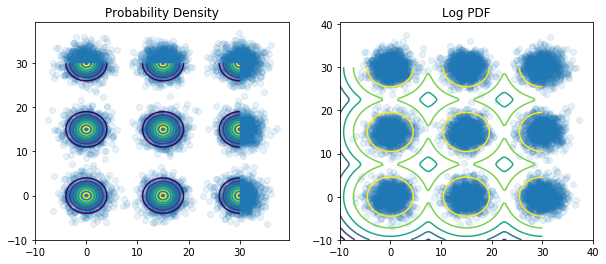

In [56]:
s = np.linspace(-10,30,100)
X,Y = np.meshgrid(s,s)
Z = [[gri2d.logp([x,y]) for x in s] for y in s]

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Probability Density')
plt.scatter(*gri2d.sample(10000).T, alpha=0.1)
plt.contour(X,Y,np.exp(Z))
plt.subplot(122)
plt.title('Log PDF')
plt.contour(X,Y,Z)
plt.scatter(*gri2d.sample(10000).T, alpha=0.1)
plt.show()

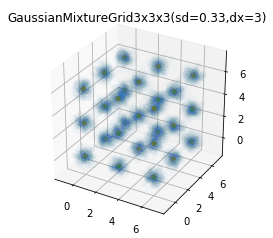

In [57]:
gri3d = GaussianMixtureGrid(3, 3, 3, 0.33)
X, Y, Z = gri3d.sample(10000).T
Xu, Yu, Zu = gri3d.means.T

ax = plt.figure(figsize=(4,4)).add_subplot(111, projection='3d')
plt.title(gri3d.name)
ax.scatter(X, Y, zs=Z, alpha=0.01)
ax.scatter(Xu, Yu, zs=Zu, c='orange')
plt.show()

# HMC vs Nuts vs Metropolis

In [61]:
N_SAMPLES = 50000
N_JOBS = 1

# NUTS
with pm.Model() as model_nuts:
  mix_nuts = gri2d.to_pymc()
  trace_nuts = pm.sample(N_SAMPLES)
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -2.2116: 100%|██████████| 200000/200000 [00:20<00:00, 9954.64it/s] 
Finished [100%]: Average ELBO = -2.2095
Evidence of divergence detected, inspect ELBO.
100%|██████████| 50000/50000 [00:39<00:00, 1270.61it/s]


In [64]:
# METROPOLIS
with pm.Model() as model_metropolis:
    # generalize start
    mix_metropolis = gri2d.to_pymc()
    trace_metropolis = pm.sample(N_SAMPLES, step=pm.Metropolis(tune=False), progressbar=True, njobs=N_JOBS)    

/usr/local/lib/python3.6/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 50000/50000 [00:11<00:00, 4520.58it/s]


In [65]:
# Now with HMC
with pm.Model() as model_HMC:
    # generalize start
    mix_HMC = gri2d.to_pymc()
    trace_HMC = pm.sample(N_SAMPLES, step=pm.HamiltonianMC(), progressbar=True, njobs=N_JOBS)    

/usr/local/lib/python3.6/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 50000/50000 [00:31<00:00, 1571.76it/s]


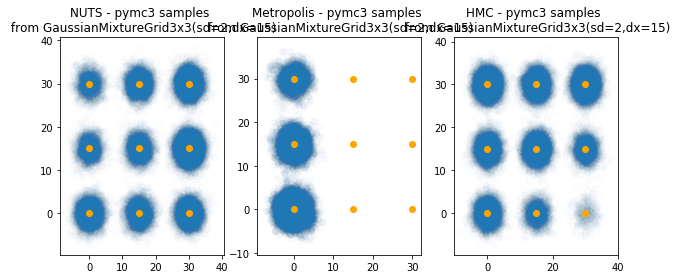

In [68]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title('NUTS - pymc3 samples \n from {}'.format(gri2d))
plt.scatter(*trace_nuts[gri2d.name].T, alpha=0.01)
plt.scatter(*gri2d.means.T, c='orange')

plt.subplot(1,3,2)
plt.title('Metropolis - pymc3 samples \n from {}'.format(gri2d))
plt.scatter(*trace_metropolis[gri2d.name].T, alpha=0.01)
plt.scatter(*gri2d.means.T, c='orange')

plt.subplot(1,3,3)
plt.title('HMC - pymc3 samples \n from {}'.format(gri2d))
plt.scatter(*trace_HMC[gri2d.name].T, alpha=0.01)
plt.scatter(*gri2d.means.T, c='orange')


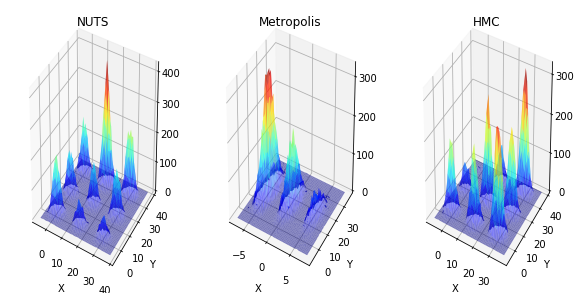

In [69]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 3, 1, projection='3d')

H, xbins, ybins = np.histogram2d(*trace_nuts[gri2d.name].T, bins=50)
X, Y = np.meshgrid(xbins[1:], ybins[1:])
ax.plot_surface(X, Y, H, cmap=cm.jet, alpha=.5)
# ax.plot_surface(X, Y, H, cmap=cm.jet, alpha=.7, rstride=20, cstride=20)
ax.set_title("NUTS")
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax = fig.add_subplot(1, 3, 2, projection='3d')
H, xbins, ybins = np.histogram2d(*trace_metropolis[gri2d.name].T, bins=50)
X, Y = np.meshgrid(xbins[1:], ybins[1:])
ax.plot_surface(X, Y, H, cmap=cm.jet, alpha=.5)
# ax.plot_surface(X, Y, H, cmap=cm.jet, alpha=.7, rstride=20, cstride=20)
ax.set_title("Metropolis")
ax.set_xlabel("X")
ax.set_ylabel("Y")


ax = fig.add_subplot(1, 3, 3, projection='3d')
H, xbins, ybins = np.histogram2d(*trace_HMC[gri2d.name].T, bins=50)
X, Y = np.meshgrid(xbins[1:], ybins[1:])
ax.plot_surface(X, Y, H, cmap=cm.jet, alpha=.5)
# ax.plot_surface(X, Y, H, cmap=cm.jet, alpha=.7, rstride=20, cstride=20)
ax.set_title("HMC")
ax.set_xlabel("X")
ax.set_ylabel("Y")




# Diagnostics

Sources:

* https://pymc-devs.github.io/pymc3/api/diagnostics.html
* https://pymc-devs.github.io/pymc3/api/plots.html
* http://rlhick.people.wm.edu/stories/bayesian_5.html
        

# Plots on offer

## 1. Posterior marginals - we would want each mode to be equally represented

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11e7585f8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11d2f3550>], dtype=object)

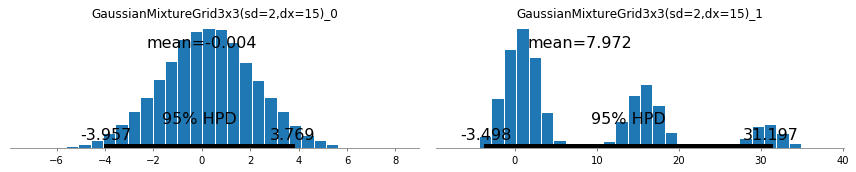

In [70]:
pm.plots.plot_posterior(trace_metropolis)

## 2. Traceplot - posterior marginals again with the trace

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e6d5518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11b50f710>]], dtype=object)

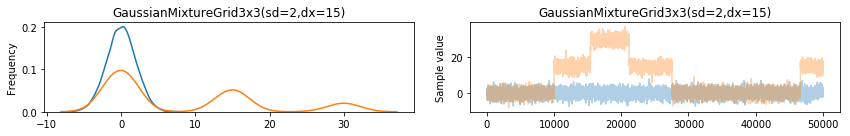

In [71]:
pm.plots.traceplot(trace_metropolis)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11783b240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d83ef28>]], dtype=object)

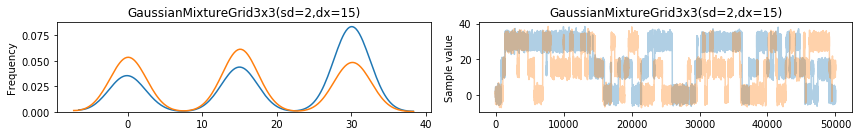

In [72]:
pm.plots.traceplot(trace_nuts)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115f1b080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11c938550>]], dtype=object)

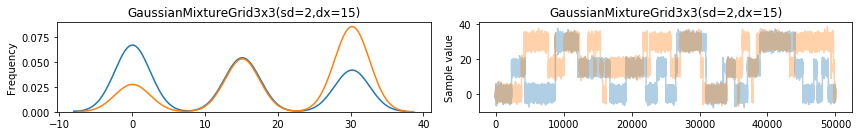

In [73]:
pm.plots.traceplot(trace_HMC)

## 3. Forestplot - don't think this one is useful to us

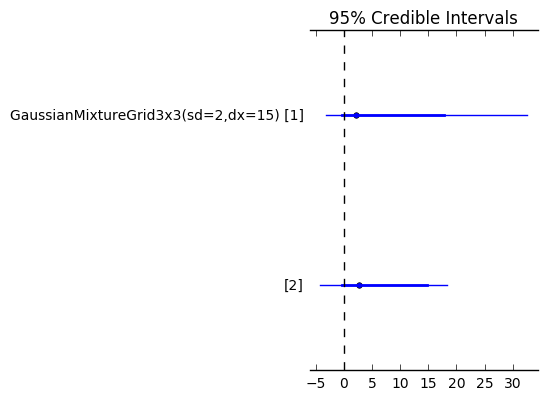

In [160]:
pm.plots.forestplot(trace_metropolis)

# Diagnostics

## 1. Autocorrelation goes down if you thin *alot*

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c4acf28>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x11e357a58>]], dtype=object)

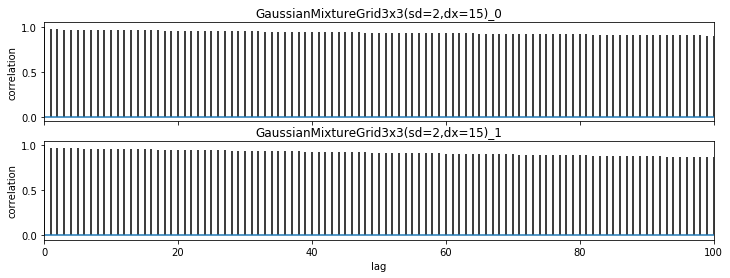

In [80]:
pm.plots.autocorrplot(trace_nuts[1000::])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b9a9550>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x11d962358>]], dtype=object)

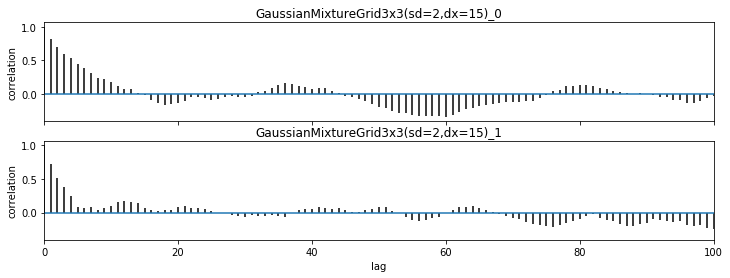

In [76]:
pm.plots.autocorrplot(trace_nuts[1000::250])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ad64e48>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x11dfbde48>]], dtype=object)

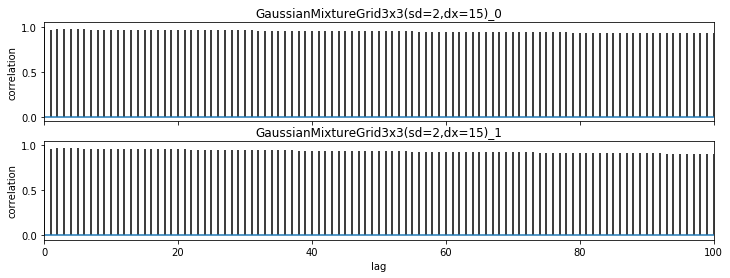

In [79]:
pm.plots.autocorrplot(trace_HMC)

## This seems sketchy. Doesn't match up with what we'd expect given traceplots above.


## 2. Geweke

* If we have adequately culled the burnin expect to fail to reject the null that the mean for the first 10% and the mean of any interval in the last 50% is the same.

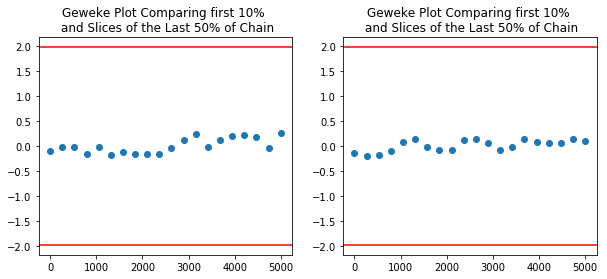

In [40]:
gw_plot = pm.geweke(trace_metropolis,.1,.5,20)

plt.figure(figsize=(10,4))
for dim, geweke_dim in enumerate(gw_plot[gri2d.name]):
    plt.subplot(1,2,dim+1)
    plt.scatter(*geweke_dim.T)
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.title('Geweke Plot Comparing first 10% \n and Slices of the Last 50% of Chain')


## 3. Gelman-Rubin

In [227]:
# METROPOLIS
with pm.Model() as model_metropolis2:
    # generalize start
    mix_metropolis2 = gri2d.to_pymc()
    trace_metropolis2 = pm.sample(N_SAMPLES, step=pm.Metropolis(), progressbar=True, njobs=2)

100%|██████████| 10000/10000 [00:00<00:00, 11446.12it/s]


In [ ]:
pm.diagnostics.gelman_rubin(trace_metropolis2)

pymc3 bugged 
* https://github.com/pymc-devs/pymc3/issues/1033
* compares between and within chain variance, so needs multiple jobs. However, when you choose njobs>1 we run into a pymc3 bug.
* rule of thumb. want this as close to 1 as possible. in particular when this is greater than 1.1 a longer burn-in is needed.

## 4. Effective Sample Size

In [ ]:
pm.diagnostics.effective_n(trace_metropolis2)

* Also expects a multitrace so sadly bugged. 
